Topic: Project 4   
Subject: Creating Models for each Subreddit  
Date: 11/10/2017   
Name: Zach Heick   

**Summary**: I vectorized the cleaned comments and their metadata to create individual models for each subreddit. 

In [1]:
import pandas as pd
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
random.seed(42)

In [3]:
with open('../Data_Files/subreddits.pickle', 'rb') as f:
    subreddits = pickle.load(f)

In [5]:
comments_d = {}
comments_sum = 0
for subreddit in subreddits:
    with open('../Data_Files/{}_comments.pickle'.format(subreddit), 'rb') as f:
        comments = pickle.load(f)
    random.shuffle(comments)
    comments_d[subreddit] = comments
    comments_sum += len(comments)
comments_sum

197427

Almost 200,000 total comments!

# Modeling Functions

In [7]:
def get_other_features(comments):
    """
    Creates train/test dataframes for features that do not include the vectorized text data.
    
    :param comments: list of dictionaries containing comment data
    :returns: Train/test dataframes
    """
    
    split = int(len(comments)* 0.70)
    
    # Create dataframes and remove comment and score columns
    train_other_features = [d for d in comments[:split]]
    train_other_features_df = pd.DataFrame(train_other_features)
    train_other_features_df.drop(['comment', 'score'], axis=1, inplace=True)
        
    test_other_features = [d for d in comments[split:]]
    test_other_features_df = pd.DataFrame(test_other_features)
    test_other_features_df.drop(['comment', 'score'], axis=1, inplace=True)
    
    ss = StandardScaler()
    
    train_scaled_features = ss.fit_transform(train_other_features_df.values)
    test_scaled_features = ss.transform(test_other_features_df.values)
    
    train_other_features_scaled_df = pd.DataFrame(train_scaled_features, 
                                              index=train_other_features_df.index,
                                              columns=train_other_features_df.columns)
    test_other_features_scaled_df = pd.DataFrame(test_scaled_features, 
                                                  index=test_other_features_df.index,
                                                  columns=test_other_features_df.columns)
    
    return train_other_features_scaled_df, test_other_features_scaled_df

In [8]:
def get_train_test_split(comments):
    """
    Creates train / test split from list of comment dictionaries.
    
    :param comments: list of dictionaries containing comment data
    :returns: Train and test dataframes with the TFIDF object and features
    """
    split = int(len(comments)* 0.70)
    
    # Get comments and scores
    train_comments = [d['comment'] for d in comments[:split]]
    train_scores = [d['score'] for d in comments[:split]]

    test_comments = [d['comment'] for d in comments[split:]]
    test_scores = [d['score'] for d in comments[split:]]
            
    # Vectorize comments
    tfidf = TfidfVectorizer(ngram_range=(1,3), max_df = 0.7, max_features=1000)
    train_comments_tfidf = tfidf.fit_transform(train_comments)
    test_comments_tfidf = tfidf.transform(test_comments)
    
    rs = RobustScaler()
    
    # Create vectorized dataframes
    train_tfidf_df = pd.DataFrame(train_comments_tfidf.toarray(), columns=tfidf.get_feature_names())
    test_tfidf_df = pd.DataFrame(test_comments_tfidf.toarray(), columns=tfidf.get_feature_names())
    
    # Scale data and create dataframe
    scaled_train_tfidf = rs.fit_transform(train_tfidf_df)
    scaled_test_tfidf = rs.transform(test_tfidf_df)
    
    scaled_train_tfidf_df = pd.DataFrame(scaled_train_tfidf)
    scaled_test_tfidf_df = pd.DataFrame(scaled_test_tfidf)

    # Get features dataframes from other comment metadata
    train_other_features_scaled_df, test_other_features_scaled_df = get_other_features(comments)
    
    # Concat vectorized and other features dataframes
    final_train_df = pd.concat([scaled_train_tfidf_df, train_other_features_scaled_df], axis=1)
    final_test_df = pd.concat([scaled_test_tfidf_df, test_other_features_scaled_df], axis=1)
    
    return final_train_df, train_scores, final_test_df, test_scores, tfidf, train_comments_tfidf

In [9]:
def classify_scores(y_train, y_test):
    """
    Bins and classifies comment scores.
    
    :param y_train: array of comment scores for training
    :param y_test: array of comment scores for testing
    :returns: binned and classified comment scores for train and test
    """
    
    max_y_train = max(y_train)
    max_y_test = max(y_test)
    
    # Create the score bins
    bins = [-10000,50,max(max_y_train, max_y_test)]
    binned_y_train = [str(item) for item in pd.cut(y_train, bins)]
    binned_y_test = [str(item) for item in pd.cut(y_test, bins)]
    
    binary_y_train = []
    binary_y_test = []

    # Classify bins into classes 0 or 1
    for item in binned_y_train:
        if item == '(-10000, 50]':
            binary_y_train.append(0)
        else:
            binary_y_train.append(1)

    for item in binned_y_test:
        if item == '(-10000, 50]':
            binary_y_test.append(0)
        else:
            binary_y_test.append(1)
            
    return binary_y_train, binary_y_test

# Parameter Tuning and Final Models

In [10]:
models_d = {}
all_features_scores = []
dummy_scores = []

for subreddit in subreddits:
    X_train, y_train, X_test, y_test, tfidf, tfidf_train = get_train_test_split(comments_d[subreddit])
    binary_y_train, binary_y_test = classify_scores(y_train, y_test)
        
    depths = [1,2,3,4,5]
    leaf_nodes = [2,3,4,5]
    param_grid = dict(max_depth = depths, max_leaf_nodes = leaf_nodes)
    
    text_features_grid = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid, cv=5, scoring='recall')
    text_features_grid.fit(X_train, binary_y_train)
    dt = DecisionTreeClassifier(class_weight='balanced', 
                                max_depth=text_features_grid.best_params_['max_depth'],
                                max_leaf_nodes=text_features_grid.best_params_['max_leaf_nodes']).fit(X_train, binary_y_train)
    pred = dt.predict(X_test)
    text_features_score = recall_score(binary_y_test, pred)
    
    dummy = DummyClassifier().fit(X_train, binary_y_train)
    dummy_pred = dummy.predict(X_test)
    dummy_score = recall_score(binary_y_test, dummy_pred)
    
    print('Subreddit: ' + subreddit + ' ---------------------------------------------')
    print('Precision')
    print('All Features: ', text_features_score)
    print('Dummy Classifier: ' + str(dummy_score))
    print('\n')
    
    all_features_scores.append(text_features_score)
    dummy_scores.append(dummy_score)
    
    X = X_train.append(X_test, ignore_index=True)
    y = binary_y_train + binary_y_test
        
    final_dt = DecisionTreeClassifier(class_weight='balanced', 
                                max_depth=text_features_grid.best_params_['max_depth'],
                                max_leaf_nodes=text_features_grid.best_params_['max_leaf_nodes']).fit(X, y)
    
    models_d[subreddit] = (final_dt, tfidf, tfidf_train)

Subreddit: politics ---------------------------------------------
Precision
All Features:  0.697360703812
Dummy Classifier: 0.372043010753


Subreddit: atheism ---------------------------------------------
Precision
All Features:  0.818954248366
Dummy Classifier: 0.111111111111


Subreddit: hiphopheads ---------------------------------------------
Precision
All Features:  0.840341880342
Dummy Classifier: 0.223931623932


Subreddit: science ---------------------------------------------
Precision
All Features:  0.655976676385
Dummy Classifier: 0.165208940719


Subreddit: worldnews ---------------------------------------------
Precision
All Features:  0.594278555022
Dummy Classifier: 0.359365211944




In [11]:
with open('RCC/models_d.pickle', 'wb') as f:
    pickle.dump(models_d, f)
    
with open('Web_App/models_d.pickle', 'wb') as f:
    pickle.dump(models_d, f)

Save the model dictionary for the web application.

# Visualizing the Models

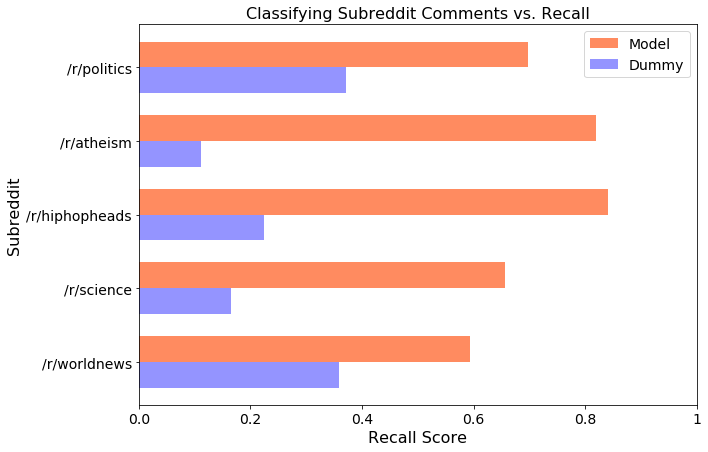

In [12]:
pos = [0,1,2,3,4]
width = 0.35
fig, ax = plt.subplots(figsize=(10,7))

plt.barh(pos, all_features_scores, width, color='#FF8b60')
plt.barh([p + width for p in pos], dummy_scores, width, color='#9494FF')
ax.set_xlim([0,1])
ax.set_yticks([p + width/2 for p in pos])
ax.set_yticklabels(['/r/politics', '/r/atheism', '/r/hiphopheads', '/r/science', '/r/worldnews'], size=14)
ax.set_xticklabels([0.0,0.2,0.4,0.6,0.8,1], size=14)

ax.set_ylabel('Subreddit', size=16)
ax.set_xlabel('Recall Score', size=16)
ax.set_title('Classifying Subreddit Comments vs. Recall', size=16)

plt.legend(['Model', 'Dummy'], loc='upper right', prop={'size':14})

ax.invert_yaxis()